In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

/home/taiger/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import utils

In [3]:
np.random.seed(1)
tf.set_random_seed(1)

In [4]:
mnist = input_data.read_data_sets('data/', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
n_crops = np.random.randint(1, 5)
n_crops

2

(array([9, 9]), array([[108, 156, 124, 190],
        [157, 130, 190, 163]]))

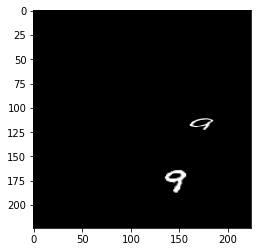

In [6]:
# use [y1, x1, y2, x2] as per original R-CNN trilogy
def make_crop(image):
    scale = np.random.uniform(0.5, 1.5, size=[2])
    w, h = (scale * 28).astype(np.int64)
    x = np.random.randint(image.shape[1] - w)
    y = np.random.randint(image.shape[0] - h)
    return y, x, y+h, x+w

def add_crop(image):
    crop, label = mnist.train.next_batch(1)
    crop = crop.reshape([28, 28])

    y1, x1, y2, x2 = make_crop(image)
    crop = cv2.resize(crop, (x2-x1, y2-y1))

    image[y1:y2, x1:x2] = crop
    return int(label), [y1, x1, y2, x2]

image = np.zeros([224, 224], np.float32)
gt_cls, gt_boxes = zip(*[add_crop(image) for i in range(n_crops)])
gt_cls, gt_boxes = map(np.array, (gt_cls, gt_boxes))

plt.imshow(image, cmap='gray')
gt_cls, gt_boxes

In [7]:
scales = [8, 16, 32, 64]
ratios = [0.5, 1.0, 2.0]
backbone_shapes = np.array([
    [56, 56],
    [28, 28],
    [14, 14],
    [7, 7],
])
strides = [4, 8, 16, 32]
anchors_per_cell = len(ratios)

In [8]:
anchors = [utils.generate_anchors(scales, ratios, shape, stride, 1) for shape, stride in zip(backbone_shapes, strides)]
anchors_per_level = [len(l) for l in anchors]
anchors = np.concatenate(anchors, axis=0)
anchors_per_level, sum(anchors_per_level)

([37632, 9408, 2352, 588], 49980)

In [9]:
ious = utils.iou(gt_boxes[0], anchors)
np.unique(np.round(ious, 2))

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.43, 0.44,
       0.45, 0.47, 0.48, 0.5 , 0.53])

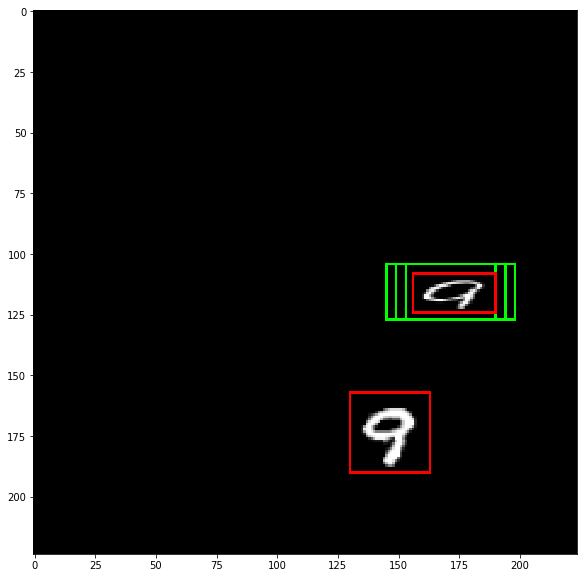

In [11]:
tmp = cv2.merge([(image * 255).astype(np.uint8)] * 3)
for y1, x1, y2, x2 in anchors[ious > 0.5]:
    x1 = int(np.maximum(0., x1))
    y1 = int(np.maximum(0., y1))
    x2 = int(np.minimum(224., x2))
    y2 = int(np.minimum(224., y2))
    cv2.rectangle(tmp, (x1, y1), (x2, y2), (0, 255, 0), 1)
for y1, x1, y2, x2 in gt_boxes:
    cv2.rectangle(tmp, (x1, y1), (x2, y2), (255, 0, 0, 3))
plt.figure(figsize=(10, 10))
plt.imshow(tmp);